## Scritp to compute Mann Kendall trends in Annual and Seasonal; written by Herbert. O. Misiani and Modified by Samuel Ekwacu

### 1. Computing Rainfall Trends Over Uganda 

In [1]:
#import shapely
#import fiona

In [2]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
## for plotting a polygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd

In [3]:
import shapefile as shp
import regionmask
from descartes import PolygonPatch
import matplotlib.path as mplPath

In [4]:
## Define the data path
home_dir = 'F:/Folder_2022/Research/chirts_EA/'
Plot_dir = 'F:/Folder_2022/Research/python_plots/trend_plots/'

In [5]:
#uploaded.keys()
in_file = 'chirps_RFE_monthly_1981-2021-EA.nc'
## Input file
Chirps = xr.open_dataset(home_dir+ in_file) ## read in the data
#Chirps

In [6]:
###########NOTE; Change appropriately below to compute either annual or Seasonal trends #########

###For Annual Trends Only
#Data=Chirps['precipitation'].groupby('T.year').mean('T')         ## Group data into yearly means for annual trends
#Data

### For Seasonal trends of MAM, JJA, SON and DJF only
Data_seas = Chirps.groupby('T.season')   ##Group data into seasonal means for seasonal trends
#Data_seas
Data_sea = Data_seas['SON']
#Data_sea
Data = Data_sea['precipitation'].groupby('T.year').mean('T') ## Group data into yearly means from seasonal mean.
#Data


In [7]:
dat_samp = Data.sel(X=slice(29.5, 35.2), Y=slice(-1.6, 4.4))  ## Slice to Uganda
slope_val = np.zeros((len(dat_samp.Y.values),len(dat_samp.X.values)))
p_value = np.zeros((len(dat_samp.Y.values),len(dat_samp.X.values)))
#output = []
for i in np.arange(len(dat_samp.Y.values)):
    for j in np.arange(len(dat_samp.X.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [8]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('Y', 'X'), coords={'Y':dat_samp.Y, 'X':dat_samp.X}, attrs=dict(description="slope.", units="mm year-1"),)
data1 = output1.rename("trend")
#sig_reg = np.ma.array(pval, mask=cond)
output2=xr.DataArray(p_value, dims=('Y', 'X'), coords={'Y':dat_samp.Y, 'X':dat_samp.X}, attrs=dict(description="significance",),)
#output2=xr.DataArray(sig_reg, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")

## Save Data as netcdf
#data.to_netcdf('tas_CanESM5_historical_trend.nc', mode='w')
#data.to_netcdf('tas_CanESM5_historical_pval.nc', mode='w')

In [9]:
## read the Shapeifle of the Area of interest for use in masking over the required region

sf = gpd.read_file('F://GIS_DATA//uga_admbnda_ubos_20200824_shp//uga_admbnda_adm0_ubos_20200824.shp')  ## Used in Masking
sf2 = shp.Reader('F://GIS_DATA//uga_admbnda_ubos_20200824_shp//uga_admbnda_adm2_ubos_20200824.shp')       ## Used in plotting
## Mask the trends and p_values

trend_mask = regionmask.mask_3D_geopandas(sf, data1.X, data1.Y, lon_name='X', lat_name='Y')
pval_mask = regionmask.mask_3D_geopandas(sf, data2.X, data2.Y, lon_name='X', lat_name='Y')

trnd = data1.where(trend_mask)         ## clip the data with the mask
pval = data2.where(pval_mask)

<ipython-input-11-eed33e53bc8b>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hatch = ax.pcolor(dat_samp.X, dat_samp.Y, sig_reg.data[:,:,0], cmap=none_map,
<ipython-input-11-eed33e53bc8b>:29: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)


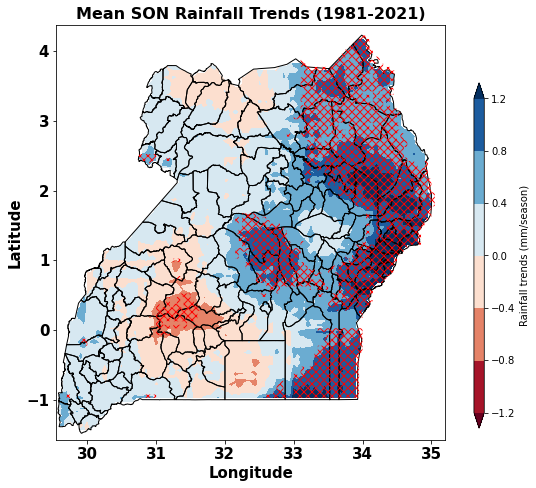

In [11]:
from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

## Change this to the threshold you need.
cond = (pval >= -0.05) & (pval <= 0.05)

## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

## Plotting the figure
for poly in sf2.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=1, fill='False', zorder=2))
    
cs = plt.contourf(dat_samp.X, dat_samp.Y, trnd.values[:,:,0],  
               levels=np.arange(-1.2, 1.6, 0.4), cmap=plt.cm.RdBu, extend='both') #RdBu #YlOrRd
## make a hatch of significance
hatch = ax.pcolor(dat_samp.X, dat_samp.Y, sig_reg.data[:,:,0], cmap=none_map, 
                 hatch='xxx', edgecolor='red', lw=0, zorder=4)
## title attributes
plt.title('Mean SON Rainfall Trends (1981-2021)',fontsize=16, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')
plt.yticks(size = 15, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=15, fontweight='bold')
plt.xlabel('Longitude',fontsize=15, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
fig.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='Rainfall trends (mm/season)')

# save output
plt.savefig(Plot_dir + 'Uganda_Chirps-SON Trends.jpeg')
plt.show()

### 2. Computing Average Temperature Trends Over Uganda

In [45]:
#uploaded.keys()
home_dir = 'F:/Folder_2022/Research/chirts_EA/'
in_file = 'chirts_tmax_monthly_1983-2016_EA.nc'
## Input file
temp = xr.open_dataset(home_dir+ in_file) ## read in the data
#temp

In [46]:
###########NOTE; Change appropriately below to compute either annual or Seasonal trends #########

###%%%%%%%% For Annual Trends Only
Data=temp['tmax'].groupby('time.year').mean('time')         ## Group data into yearly means for annual trends
#Data

###%%%%%%%%% For Seasonal trends of MAM, JJA, SON and DJF only
#Data_seas = temp.groupby('time.season')   ##Group data into seasonal means for seasonal trends
#Data_seas
#Data_sea = Data_seas['SON']
#Data_sea
#Data = Data_sea['precipitation'].groupby('T.year').mean('T') ## Group data into yearly means from seasonal mean.
#Data


In [47]:
dat_samp = Data.sel(X=slice(29.5, 35.2), Y=slice(-1.6, 4.4))
slope_val = np.zeros((len(dat_samp.Y.values),len(dat_samp.X.values)))
p_value = np.zeros((len(dat_samp.Y.values),len(dat_samp.X.values)))
#output = []
for i in np.arange(len(dat_samp.Y.values)):
    for j in np.arange(len(dat_samp.X.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [48]:
## Define data as Xarray dataset and save as netcdf

output1=xr.DataArray(slope_val, dims=('Y', 'X'), coords={'Y':dat_samp.Y, 'X':dat_samp.X}, attrs=dict(description="slope.", units="mm year-1"),)
data1 = output1.rename("trend")
#sig_reg = np.ma.array(pval, mask=cond)
output2=xr.DataArray(p_value, dims=('Y', 'X'), coords={'Y':dat_samp.Y, 'X':dat_samp.X}, attrs=dict(description="significance",),)
#output2=xr.DataArray(sig_reg, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")

## Save Data as netcdf

#data.to_netcdf('tas_CanESM5_historical_trend.nc', mode='w')
#data.to_netcdf('tas_CanESM5_historical_pval.nc', mode='w')

In [49]:
## read the Shapeifle of the Area of interest for use in masking over the required region

sf = gpd.read_file('F://GIS_DATA//uga_admbnda_ubos_20200824_shp//uga_admbnda_adm0_ubos_20200824.shp')  ## Used in Masking
sf2 = shp.Reader('F://GIS_DATA//uga_admbnda_ubos_20200824_shp//uga_admbnda_adm2_ubos_20200824.shp')       ## Used in plotting
## Mask the trends and p_values

trend_mask = regionmask.mask_3D_geopandas(sf, data1.X, data1.Y, lon_name='X', lat_name='Y')
pval_mask = regionmask.mask_3D_geopandas(sf, data2.X, data2.Y, lon_name='X', lat_name='Y')

trnd = data1.where(trend_mask)         ## clip the data with the mask
pval = data2.where(pval_mask)

<ipython-input-50-6d5655ea1b50>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hatch = ax.pcolor(dat_samp.X, dat_samp.Y, sig_reg.data[:,:,0], cmap=none_map,
<ipython-input-50-6d5655ea1b50>:29: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)


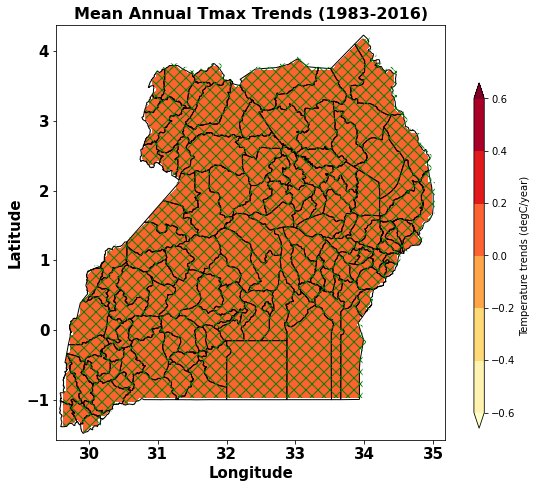

In [50]:
from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

## Change this to the threshold you need.
cond = (pval >= -0.05) & (pval <= 0.05)

## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

## Plotting the figure
for poly in sf2.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=1, fill='False', zorder=2))
    
cs = plt.contourf(dat_samp.X, dat_samp.Y, trnd.values[:,:,0],  
               levels=np.arange(-0.6, 0.8, 0.2), cmap=plt.cm.YlOrRd, extend='both') #RdBu #YlOrRd
## make a hatch of significance
hatch = ax.pcolor(dat_samp.X, dat_samp.Y, sig_reg.data[:,:,0], cmap=none_map, 
                 hatch='XX', edgecolor='green', lw=0, zorder=4)
## title attributes
plt.title('Mean Annual Tmax Trends (1983-2016)',fontsize=16, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')
plt.yticks(size = 15, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=15, fontweight='bold')
plt.xlabel('Longitude',fontsize=15, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#cax = plt.axes([0.85, 0.1, 0.018, 0.6])
#plt.colorbar(cax=cax)
fig.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='Temperature trends (degC/year)')
# save output
plt.savefig(Plot_dir + 'Uganda_TEMP_GHCN-Annual Trends.jpeg')
plt.show()

### God Provides